In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.datasets import MNIST


# Загрузка данных MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

#Простая модель для обучения
class EmbeddingNet(nn.Module):
   def __init__(self):
       super(EmbeddingNet, self).__init__()
       self.fc1 = nn.Linear(50 * 37, 128)
       self.fc2 = nn.Linear(128, 64)
       self.fc3 = nn.Linear(64, 32)  # Embedding размерности 32

   def forward(self, x):
       x = x.view(x.size(0), -1)  # Flatten изображение
       x = torch.relu(self.fc1(x))
       x = torch.relu(self.fc2(x))
       x = self.fc3(x)
       return x


In [2]:
from sklearn.datasets import fetch_lfw_people

In [3]:
# Загрузка LFW dataset
from torch.utils.data import DataLoader, TensorDataset
faces = fetch_lfw_people(min_faces_per_person=53, resize=0.4)  # resize=0.4 для уменьшения размера изображений
print(f"Number of classes: {len(faces.target_names)}")  # Количество уникальных людей
print(f"Shape of images: {faces.images.shape}")  # Размер изображений (n_samples, 50, 37)

# Преобразуем данные в тензоры PyTorch
images = torch.tensor(faces.images, dtype=torch.float32).unsqueeze(1)  # Добавляем канал (n_samples, 1, 50, 37)
labels = torch.tensor(faces.target, dtype=torch.int64)

# Определяем трансформации
transform = transforms.Compose([#transforms.Resize((28, 28)),
    transforms.Normalize((0.5,), (0.5,)) # Нормализация (приводит значения к диапазону [-1, 1])
])

# Применяем трансформации к данным
images = transform(images)

# Создаем Dataset и DataLoader
train_dataset = TensorDataset(images, labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Number of classes: 10
Shape of images: (1456, 50, 37)


In [4]:
# Проверка формы данных
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")  # Ожидаемый размер: (512, 1, 28, 28)
    print(f"Batch labels shape: {labels.shape}") 
    print(labels)# Ожидаемый размер: (512,)
    break

Batch images shape: torch.Size([8, 1, 50, 37])
Batch labels shape: torch.Size([8])
tensor([3, 1, 3, 3, 3, 9, 1, 6])


In [5]:
# Создаем CNN модель
class ConvEmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super(ConvEmbeddingNet, self).__init__()
        # Первый сверточный слой
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Второй сверточный слой
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        
        # Flatten и полносвязный слой для эмбеддингов
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*6*4, embedding_dim)  # 7x7 — размер feature map после пулинга

    def forward(self, x):
        # Первый сверточный блок
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Второй сверточный блок
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)      
        # Flatten и полносвязный слой
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [6]:
import torch
torch.__version__

'2.5.0+cu124'

In [7]:
device="cuda:0"
model = ConvEmbeddingNet()
model.to(device)
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
model = torch.load("cnnnet.pt")


C:\Users\wmama\AppData\Local\Temp\ipykernel_11604\1797060660.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("cnnnet.pt")


In [9]:
model.to(device)

ConvEmbeddingNet(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1536, out_features=32, bias=True)
)

In [10]:
model(torch.rand( 1,1,50, 37, requires_grad=True).to(device)).shape

torch.Size([1, 32])

In [28]:
# Функция для создания троек
def create_triplets(images, labels):
    triplets = []
    for i in range(len(images)):
        anchor = images[i]
        anchor_label = labels[i]

        # Выбираем positive пример (того же класса)
        positive_indices = (labels == anchor_label).nonzero().squeeze()
        
        positive = images[positive_indices[torch.randint(0, len(positive_indices), (1,))]]

        # Выбираем negative пример (другого класса)
        negative_indices = (labels != anchor_label).nonzero().squeeze()
        negative = images[negative_indices[torch.randint(0, len(negative_indices), (1,))]]

        triplets.append((anchor, positive, negative))
    return triplets

In [11]:
import torch

def create_triplets(images, labels):
    """
    Создает тройки (anchor, positive, negative) для обучения с TripletLoss.
    
    Args:
        images (torch.Tensor): Тензор изображений размером (N, C, H, W).
        labels (torch.Tensor): Тензор меток размером (N,).
    
    Returns:
        list: Список троек (anchor, positive, negative).
    """
    triplets = []
    unique_labels = torch.unique(labels)  # Уникальные классы

    for label in unique_labels:
        # Индексы для текущего класса (anchor и positive)
        label_indices = (labels == label).nonzero().squeeze()
        if label_indices.dim() == 0:  # Если это скаляр, преобразуем в 1D тензор
            label_indices = label_indices.unsqueeze(0)
        num_label_samples = len(label_indices)
         #if num_label_samples < 2:
         #   continue  

        # Индексы для negative (другие классы)
        negative_indices = (labels != label).nonzero().squeeze()
        if negative_indices.dim() == 0:  # Если это скаляр, преобразуем в 1D тензор
            negative_indices = negative_indices.unsqueeze(0)
        num_negative_samples = len(negative_indices)
        #if num_negative_samples == 0:
        #    continue

        # Создаем тройки для текущего класса
        for i in range(num_label_samples):
            anchor_idx = label_indices[i]
            anchor = images[anchor_idx]

            # Выбираем positive (случайный элемент того же класса)
            positive_idx = label_indices[torch.randint(0, num_label_samples, (1,))]
            positive = images[positive_idx]

            # Выбираем negative (случайный элемент другого класса)
            negative_idx = negative_indices[torch.randint(0, num_negative_samples, (1,))]
            negative = images[negative_idx]

            triplets.append((anchor, positive, negative))

    return triplets

In [50]:
# Обучение модели
model.to(device)
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        # Создаем тройки
        try:
            triplets = create_triplets(images, labels)
        except:
            continue
        

        # Вычисляем потери для каждой тройки
        loss = 0
        for anchor, positive, negative in triplets:
            anchor =anchor.reshape(-1,1,50,37)
            #print(anchor.shape)
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            loss += criterion(anchor_embed, positive_embed, negative_embed)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}')



Epoch [1/25], Batch [0/167], Loss: 0.0000
Epoch [1/25], Batch [100/167], Loss: 0.0000
Epoch [1/25], Average Loss: 0.1506
Epoch [2/25], Batch [0/167], Loss: 0.0000
Epoch [2/25], Batch [100/167], Loss: 0.0000
Epoch [2/25], Average Loss: 0.4308
Epoch [3/25], Batch [0/167], Loss: 0.0000
Epoch [3/25], Batch [100/167], Loss: 3.0056
Epoch [3/25], Average Loss: 0.1737
Epoch [4/25], Batch [0/167], Loss: 0.0000
Epoch [4/25], Batch [100/167], Loss: 0.0000
Epoch [4/25], Average Loss: 0.3042
Epoch [5/25], Batch [0/167], Loss: 0.0000
Epoch [5/25], Batch [100/167], Loss: 0.0000
Epoch [5/25], Average Loss: 0.2120
Epoch [6/25], Batch [0/167], Loss: 0.0000
Epoch [6/25], Batch [100/167], Loss: 0.0000
Epoch [6/25], Average Loss: 0.1934
Epoch [7/25], Batch [0/167], Loss: 0.0000
Epoch [7/25], Batch [100/167], Loss: 0.0000
Epoch [7/25], Average Loss: 0.2513
Epoch [8/25], Batch [0/167], Loss: 0.0000
Epoch [8/25], Batch [100/167], Loss: 0.0000
Epoch [8/25], Average Loss: 0.2513
Epoch [9/25], Batch [0/167], Los

In [56]:
torch.save(model,'cnnnet.pt')

In [11]:
# Получаем embeddings для всего датасета
model.eval()
embeddings = []
labels_list = []
with torch.no_grad():
    for images, labels in train_loader:
        embeddings.append(model(images.to(device)))
        labels_list.append(labels)
embeddings = torch.cat(embeddings).cpu().numpy()
labels_list = torch.cat(labels_list).cpu().numpy()

In [13]:
embeddings.shape

(1456, 32)

In [14]:
import faiss

In [15]:
dimension = len(embeddings[0])
index = faiss.IndexFlatIP(dimension)
index = faiss.IndexIDMap(index)
vectors = np.array(embeddings).astype(np.float32)
index.add_with_ids(vectors, np.array(range(len(embeddings))))

In [18]:
faiss.write_index(index, "vector.index")

In [30]:
labels_list

array([0, 1, 7, ..., 2, 1, 3], dtype=int64)

In [19]:
embeddings[0]

array([ 1.5227174 , -1.5196414 ,  2.283518  ,  1.4327793 , -3.5404954 ,
        1.1505052 , -5.0096354 , -3.4445798 ,  0.99505085,  0.76081944,
       -2.5718865 , -0.5678515 , -1.5074644 ,  5.0810657 ,  0.6507635 ,
       -0.39076304, -4.795657  ,  2.4477148 ,  1.5083017 ,  1.5557961 ,
        0.4179456 , -1.9161477 ,  0.16503869,  0.7808575 ,  2.375307  ,
        2.3927875 ,  1.8648258 ,  0.75101125,  2.1925042 ,  1.9614373 ,
       -1.380903  ,  1.122823  ], dtype=float32)

In [16]:
distances, indices = index.search(embeddings[1].reshape(1, -1), 3)

In [17]:
distances

array([[151.64801, 140.90558, 132.47955]], dtype=float32)

In [18]:
indices

array([[ 773, 1106,  195]])

In [19]:
labels_list[[773, 1106,  195]]

array([8, 8, 8])

In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [59]:
# Применяем t-SNE для уменьшения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

In [301]:
#train_dataset.tensors[0].numpy()

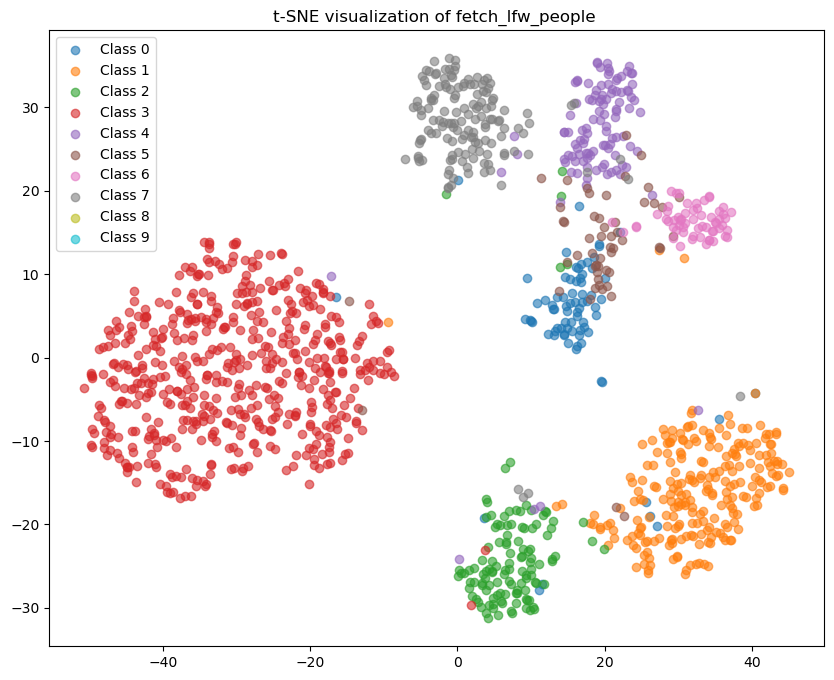

In [60]:
plt.figure(figsize=(10, 8))
for i in range(10):  # MNIST имеет 10 классов
    plt.scatter(embeddings_tsne[labels_list == i, 0], embeddings_tsne[labels_list == i, 1], label=f'Class {i}', alpha=0.6)
plt.title('t-SNE visualization of fetch_lfw_people ')
plt.legend()
plt.savefig("res.png")
plt.show()


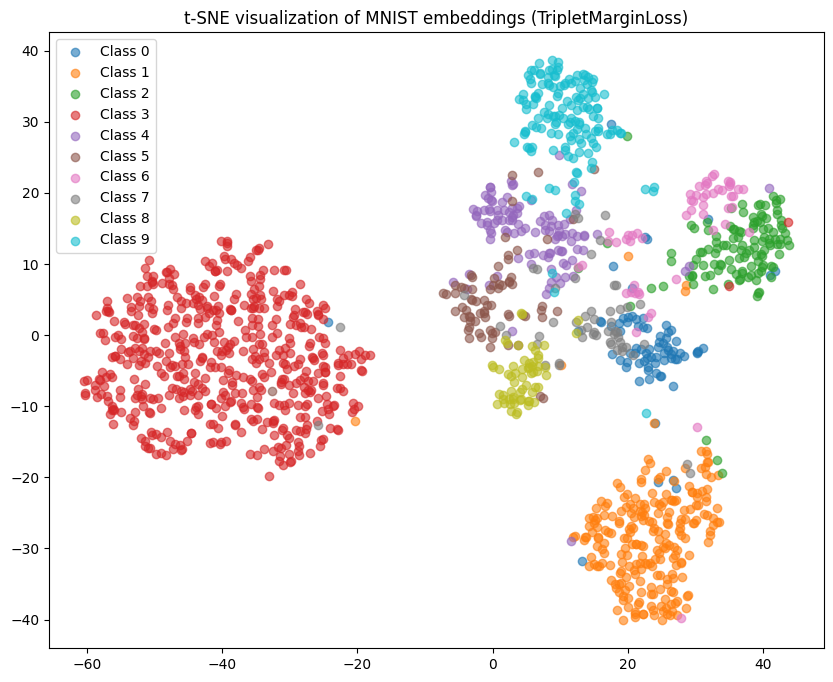

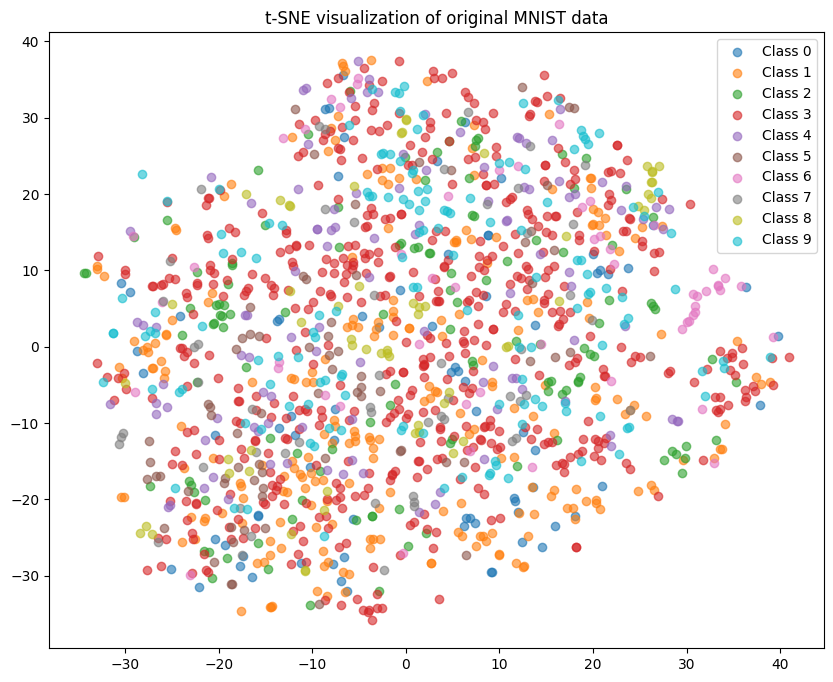

In [341]:
# Визуализация
plt.figure(figsize=(10, 8))
for i in range(10):  # MNIST имеет 10 классов
    plt.scatter(embeddings_tsne[labels_list == i, 0], embeddings_tsne[labels_list == i, 1], label=f'Class {i}', alpha=0.6)
plt.title('t-SNE visualization of MNIST embeddings (TripletMarginLoss)')
plt.legend()
plt.show()

# Сравнение с исходными данными
# Применяем t-SNE к исходным данным
images_all = train_dataset.tensors[0].numpy().reshape(-1, 50 * 37) / 255.0  # Нормализация
labels_all = train_dataset.tensors[1].numpy()

tsne = TSNE(n_components=2, random_state=42)
images_tsne = tsne.fit_transform(images_all)

# Визуализация
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(images_tsne[labels_all == i, 0], images_tsne[labels_all == i, 1], label=f'Class {i}', alpha=0.6)
plt.title('t-SNE visualization of original MNIST data')
plt.legend()
plt.show()